### Requirements

#### Python packages

The following packages are not required by <i>nscsim</i> but are needed to run this notebook

- [cython](https://pypi.org/project/Cython/)
- [MDAnalysis](https://pypi.org/project/MDAnalysis/)
- [periodictable](https://pypi.org/project/periodictable/)

### Requirements

In [1]:
Does everything look good? Mark the review as Approve. A member of @nscsim/gatekeepers will take care of it.

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import MDAnalysis as mda
import periodictable
import nscsim
from nscsim.quasielastic import incoherent as incoh
from nscsim.qvec import moduli_linscale
from nscsim import plotting

### Download water simulation
`wget` and `tar` commands are necessary.  
You may skip this step if running the notebook more than once

In [2]:
%%capture
%%bash
wget https://www.dropbox.com/s/7imfnz6ma1kh41w/water_4000.tar.gz
tar zxf water_4000.tar.gz

### Create system and extract coordinates

`u` is a `MDAnalysis.Universe` object. It contains 154 Lithium atoms, 154 Chloride atoms, and 1128 TIP3 water molecules.

In [3]:
u = mda.Universe('topology.psf', 'trajectory.dcd')

We investigate the trajectory.

In [4]:
print('number of conformations =', u.trajectory.n_frames)
print('Size of the box, in Angstroms =', u.dimensions[0:3])
print('It is a cubic box, as evidenced by the angles between box sides: ',u.dimensions[3:])

number of conformations = 4000
Size of the box, in Angstroms = [33.6035 33.6035 33.6035]
It is a cubic box, as evidenced by the angles between box sides:  [90. 90. 90.]


Select only the hydrogens and oxygens. There should be three atoms per water molecule. A look at file <i>topology.psf</i> shows that water hydrogens have type `HT` and water oxygens have type `OT`

In [5]:
sel = u.select_atoms('type HT or type OT')
print('number of atoms selected =', len(sel))
print('number of atoms per water molecule = ', len(sel)/len(sel.residues))

number of atoms selected = 3384
number of atoms per water molecule =  3.0


Obtain the bound incoherent neutron scattering cross sections for the atoms of our selection `sel`. Notice we have to "translate" from NAMD atom types to the name of the atomic element. We use dictionary `type_to_element` for this. Then we iterate over our selected atoms

### Calculate the incoherent dynamic structure factor `S(q, t)`

The liquid allows to compute scattering only as a function of Q-vector modulus so we carry out a spherical average for all orientations of vector Q (function `intermediate_spherical`).

In [7]:
q_mod = moduli_linscale(0.1, q_mod_max=2.1, q_mod_delta=0.2)
# Extract coordinates to numpy array with shape=(#atoms, #frames, 3)
tr = np.asarray([sel.positions for _ in u.trajectory[0:1000:1]])  # shape=(#frames, #atoms, #3)
tr = tr.transpose((1,0,2))  # shape=(#atoms, #frames, 3)

In [8]:
type_to_element = dict(HT='H', OT='O')
xi = np.asarray([getattr(periodictable, type_to_element[at.type]).neutron.incoherent for at in sel])
print(xi[0:9])
bi = np.sqrt(xi)  # incoherent.intermediate_spherical module requires bi instead of xi

[ 0.   80.26 80.26  0.   80.26 80.26  0.   80.26 80.26]


In [ ]:
results = incoh.self_intermediate_spherical(q_mod, tr, bi, nt=500, n_cores=8)
sf, times = results.sf, results.t

In [12]:
import nscsim.quasielastic.incoherent2 as inc2

In [47]:
import importlib
importlib.reload(inc2)

<module 'nscsim.quasielastic.incoherent2' from '/home/39p/projects/nscsim/nscsim/quasielastic/incoherent2.py'>

In [46]:
sf2 = inc2.intermediate_spherical(tr, q_mod, bi, n_cores=8)


Calculating coherent scattering for a set of q-moduli



















  0%|          | 0/10 [00:00<?, ?it/s]
Calculating incoherent intensities for one set of q vectors



> /home/39p/projects/nscsim/nscsim/quasielastic/incoherent2.py(70)intermediate_vector_set()
-> result = np.sum(result)
(Pdb) obj = next(result)
*** ValueError: object too deep for desired array
(Pdb) serial_worker(tr[0], s_inc[0])
*** ValueError: object too deep for desired array
(Pdb) tr[0]
array([[ 15.827579 , -15.575326 ,   9.810642 ],
       [ 15.530334 , -15.732183 ,   9.759977 ],
       [ 15.9462805, -15.673354 ,  10.000448 ],
       ...,
       [ 13.059978 , -21.137667 ,  19.665363 ],
       [ 13.388484 , -21.850504 ,  19.279696 ],
       [ 14.395192 , -20.926067 ,  19.130993 ]], dtype=float32)
(Pdb) s_inc[0]
2.4093567606313515
(Pdb) serial_worker
<function intermediate_vector_set.<locals>.serial_worker at 0x7f5e484146a8>
(Pdb) ai = np.exp(-1j*np.tensordot(q, tr[0],axes=(1,1)))  
(Pdb) ai
array([[-0.410982  -0.91164346j, -0.40732624-0.91328272j,
        -0.43242458-0.90167011j, ..., -0.9922127 -0.12455505j,
        -0.99363402-0.11265626j, -0.98944188-0.14493019j],
       [-0.50

KeyboardInterrupt: 

In [50]:
import numpy as np

In [51]:
np.save('tr_ref.npy', tr)
np.save('q_mod_ref.npy', q_mod)
np.save('bi_ref.npy', bi)

Simple plotting of the curve.

<IPython.core.display.Javascript object>


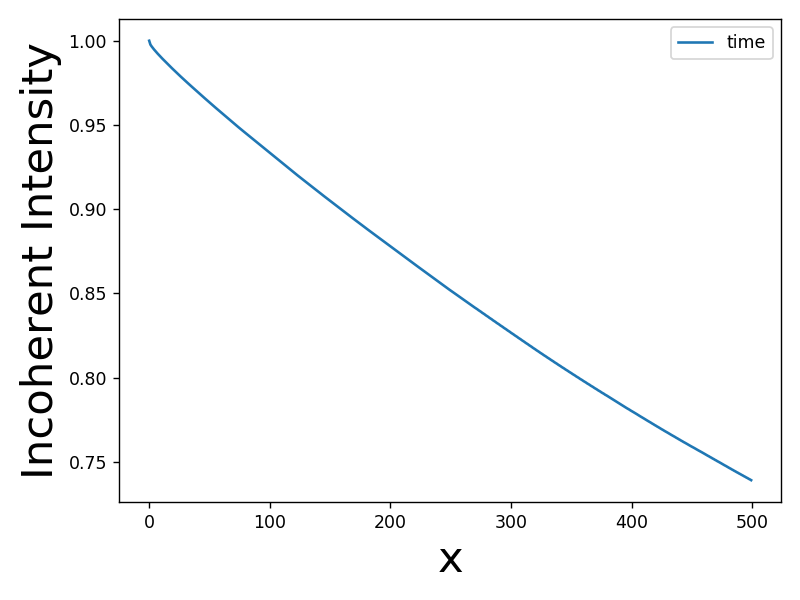

In [9]:
plotting.single_curve(times, sf[0], label='time', ylabel='Incoherent Intensity')

Notice that at long times the scattering is not reliable due to low statistical sampling. A more reliable curve at times~1000 can be obtained if we use all frames, not just the first 1000:

<code>tr = np.asarray([sel.positions for _ in u.trajectory[::1]]) # all frames in the trajectory</code>

Plot all curves sequentially

### Calculate the coherent dynamic structure factor `S(q)` in a log scale of Q-values

We will calculate more values of Q using the first 100 oxygen atoms and all the trajectory frames. Here we calculate scattering from `Q=0.01` to `Q=10` for a total of 15 Q-values spaced in a log scale.

In [ ]:
common = dict(xlabel='time', ylabel='Incoherent Intensity', xscale='linear', yscale='linear')
for i, curve in enumerate(sf):
    common['label'] = 'Q={:.2f}'.format(q_mod[i])
    plotting.single_curve(times, curve, **common)